In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import os
pi = np.pi

In [22]:
# flows directory is in Zenodo dataset or can be generated by code in CalculateFlows
flowsdir = '../publicdataset/flows/FS/'
os.listdir(flowsdir)

['Wy_20', 'Wy_50']

In [23]:
alphasdeg = np.linspace(40,-60,11) #elevations
alphas = np.multiply(pi/180,alphasdeg)
ncams = 2
maxframe = 400-9
res = 5
pixperdeg = 1
patchsz = 25
fps = 100
dates = [f'Oct1{i}' for i in range(2,10) if i != 8]
dates

['Oct12', 'Oct13', 'Oct14', 'Oct15', 'Oct16', 'Oct17', 'Oct19']

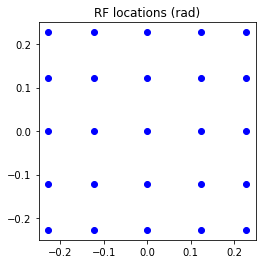

In [24]:
# spatial sampling of RFs

outres = 5
RFxs,RFys = np.meshgrid(np.linspace(0,40,outres+2),np.linspace(0,40,outres+2))
RFxs=np.rint(np.ndarray.flatten(RFxs[1:-1,1:-1])).astype('uint8')
RFys=np.rint(np.ndarray.flatten(RFys[1:-1,1:-1])).astype('uint8')

# convert to radians for flow calculations
pi = np.pi
xxdeg = (RFxs.astype('float')-20)
yydeg = (RFys.astype('float')-20)
xx = xxdeg*pi/180
yy = yydeg*pi/180

plt.scatter(xx,yy,c='b')
plt.gca().set_aspect('equal')
plt.title('RF locations (rad)');

In [25]:
# load data from good day
data = np.load(flowsdir+'Wy_50/Wy_50_Oct12.npz')
xflow = data['xflow']
yflow = data['yflow']
grad = data['grad']
cond = data['cond']
np.shape(xflow)

(2, 11, 391, 25)

-41.93728486359035 -41.80661862771751


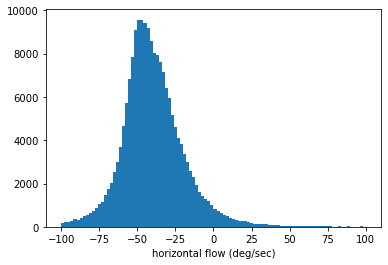

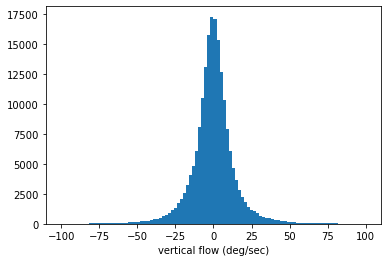

In [26]:
_ = plt.hist(np.ndarray.flatten(xflow),bins=100,range=[-100,100])
plt.xlabel('horizontal flow (deg/sec)')
plt.figure()
_ = plt.hist(np.ndarray.flatten(yflow),bins=100,range=[-100,100])
plt.xlabel('vertical flow (deg/sec)')
print(np.nanmedian(xflow),np.nanmean(xflow))

In [27]:
# make ground truth templates

def pitch(a):
    return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])

def yaw(a):
    return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])

def roll(a):
    return np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]])

def makeR(theta,alpha=0,gamma=0):
    return np.matmul(np.matmul(roll(gamma),pitch(alpha)),yaw(theta))

def getflow_local(x=xx,y=yy,yaw=0,pitch=0,f=1.0,Xdot=0,Ydot=0,Zdot=0,Wx=0,Wy=0,Wz=0,V0=None,geometry='sphere',flipy=False,newfig=True,ret=True,plot=False):
 
    if V0 is None:
        V0 = [[Xdot,Ydot,Zdot],[Wx,Wy,Wz]]
        
    R = makeR(yaw,pitch)
    V = np.transpose(np.matmul(R,np.transpose(V0)))
    Xdot,Ydot,Zdot = V[0]
    Wx,Wy,Wz = V[1]

    if flipy:
        y = -y
        x = -x
    
    if isinstance(geometry,float):
        mu = geometry
    elif geometry == 'const':
        mu = 1
    elif geometry == 'sphere':
        mu = 1/np.sqrt(1-(x**2+y**2))
    elif geometry == 'floor':
        mu = -np.sin(pitch+np.arctan2(y,f))
        mu[mu<0] = 0    
    elif geometry == 'floorceil':
        mu = np.abs(np.sin(pitch+np.arctan2(y,f)))
    elif geometry == 'floorceilsnell':
        mu = np.abs(np.sin(pitch+np.arctan2(y,f)))
        mu[(pitch+np.arctan2(y,f))>42*pi/180] = 0
    elif geometry == 'hybrid':
        mu = 10*np.abs(np.sin(pitch+np.arctan2(y,f))) # 10 cm above/10 cm below (Z*.1m -> mu*10/m)
        mu[(pitch+np.arctan2(y,f))>42*pi/180] = 0
    elif geometry == 'smallsphere':
        mu = 10/np.sqrt(1-(x**2+y**2)) # 10 cm sphere to match hybrid geometry
    else:
        print('invalid geometry, using const')
        mu = 1.0
        
    dx = Xdot*f*mu + -Zdot*mu*x - Wx*x*y/f + Wy*(f**2+x**2)/f - Wz*y
    dy = Ydot*f*mu + -Zdot*mu*y - Wx*(f**2+y**2)/f + Wy*x*y/f + Wz*x
    flow = np.stack([dx,dy],axis=-1)
    
    if plot:
        if newfig:
            plt.figure()
        flowincolor(flow)
        plt.quiver(dx,-dy)
        plt.title(f'translation: {Xdot:.2f}, {Ydot:.2f}, {Zdot:.2f}, \nrotation: {Wx:.2f}, {Wy:.2f}, {Wz:.2f}')
    
    if ret:
        return flow

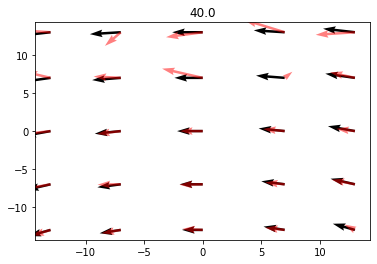

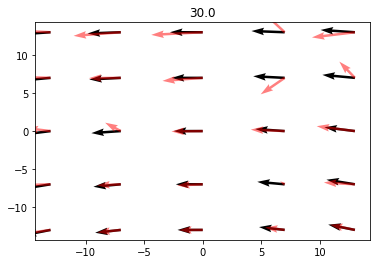

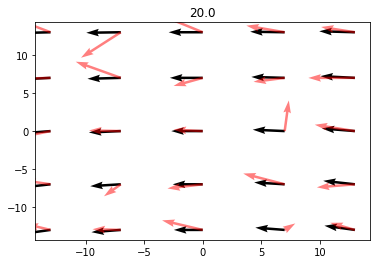

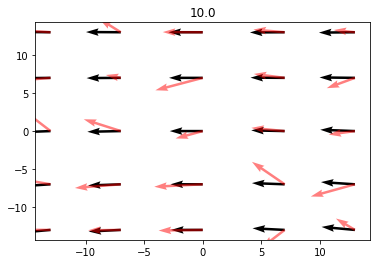

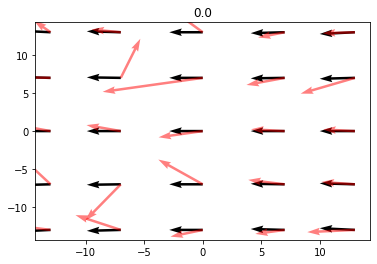

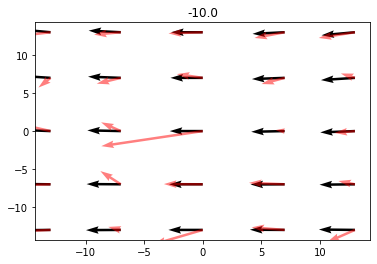

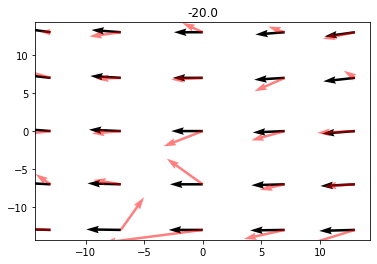

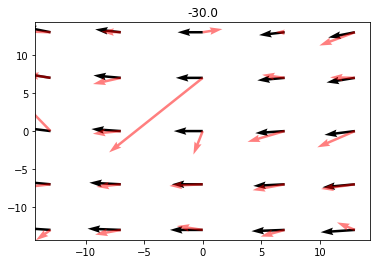

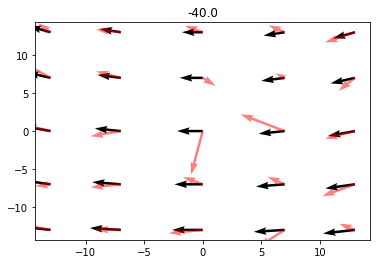

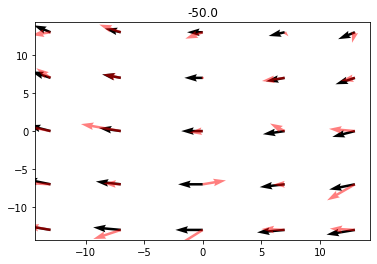

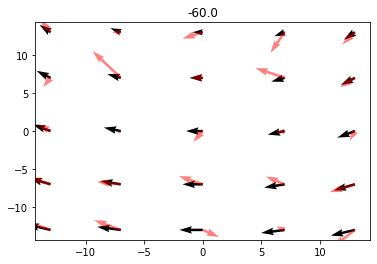

In [28]:
gt = np.nan*np.ones([ncams,len(alphasdeg),res*res,2])
i = 50 # random frame to show
qscale = 500
for a in range(len(alphasdeg)):
    gt[0,a,:,:] = getflow_local(x=xx,y=yy,pitch=alphas[a],Wy=-50*pi/180,geometry='const') # geometry doesn't matter for pure rotation
    gt = gt*180/pi
    plt.figure()
    plt.quiver(xxdeg,yydeg,gt[0,a,:,0],gt[0,a,:,1],scale=qscale)
    plt.quiver(xxdeg,yydeg,xflow[0,a,i,:],yflow[0,a,i,:],color='r',alpha=.5,scale=qscale)
    plt.title(alphasdeg[a])

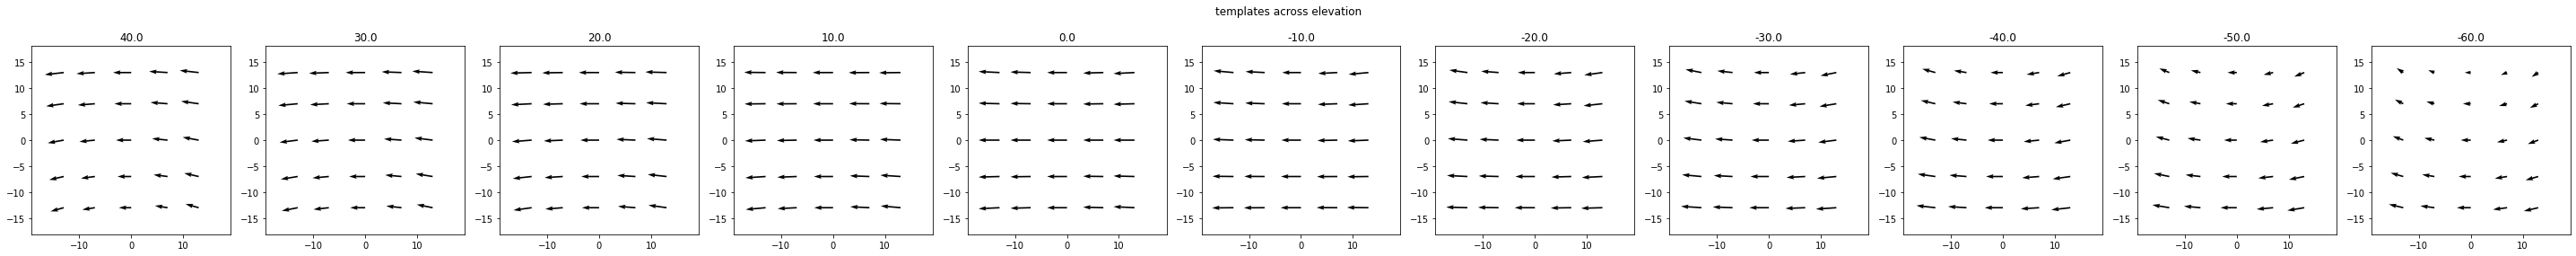

In [29]:
# show ground truth flows

plt.figure(figsize=(40,4))
s = 500
for a in range(len(alphas)):
    Wy_50_gt = getflow_local(Wy=-50*pi/180,pitch=alphas[a])*180/pi
    plt.subplot(1,len(alphas),a+1)
    plt.quiver(xxdeg,yydeg,Wy_50_gt[:,0],Wy_50_gt[:,1],scale=s)
    plt.axis('equal')
    plt.title(alphasdeg[a])
plt.suptitle(f'templates across elevation');
plt.tight_layout()

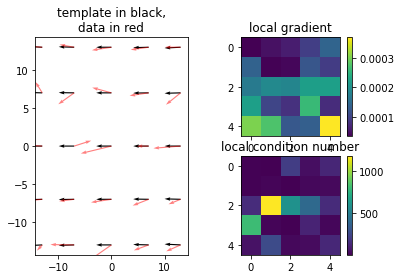

In [30]:
# show sample flow

data = np.load(f'{flowsdir}Wy_50/Wy_50_Oct12.npz',allow_pickle=True)
cam = 0
elev = 4
frame = 10

plt.figure()
plt.subplot(1,2,1)
gt = getflow_local(Wy=-50*pi/180,pitch=alphas[elev])*180/pi
plt.quiver(xxdeg,yydeg,gt[:,0],gt[:,1],scale=s)
plt.quiver(xxdeg,yydeg,data['xflow'][cam,elev,frame],data['yflow'][cam,elev,frame],scale=s,color='r',alpha=.5)
plt.title('template in black,\ndata in red')
plt.subplot(2,2,2)
plt.imshow(np.reshape(data['grad'][cam,elev,frame],[5,5]))
plt.colorbar()
plt.title('local gradient')
plt.subplot(2,2,4)
plt.imshow(np.reshape(data['cond'][cam,elev,frame],[5,5]))
plt.colorbar()
plt.title('local condition number');

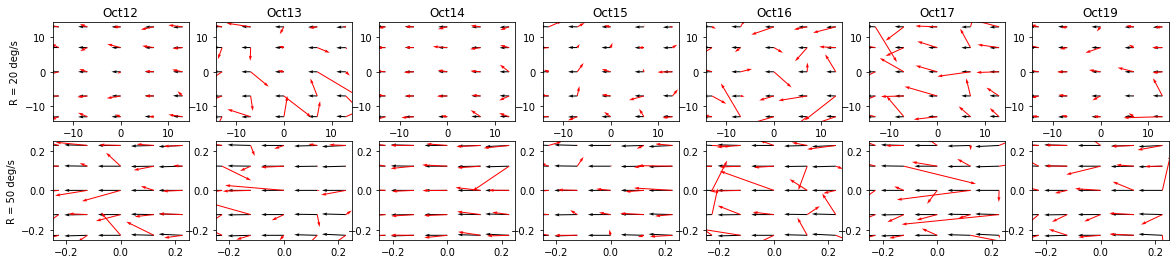

In [31]:
# show one flow from each site to check sign - some missing due to key frames
cam = 0
elev = 4
frame = 20

# ground truth for both rotation speeds
gt20 = getflow_local(Wy=-20*pi/180,pitch=alphas[elev])*180/pi
gt50 = getflow_local(Wy=-50*pi/180,pitch=alphas[elev])*180/pi


s = 300
plt.figure(figsize=(20,4))
for d,date in enumerate(dates):
    # pick different frame for Oct 17 to avoid keyframe
    if d == 5:
        frame = 30
    data = np.load(f'{flowsdir}Wy_20/Wy_20_{date}.npz',allow_pickle=True)
    plt.subplot(2,len(dates),d+1)
    plt.title(date);
    plt.quiver(xxdeg,yydeg,gt20[:,0],gt20[:,1],scale=s)
    plt.quiver(xxdeg,yydeg,data['xflow'][cam,elev,frame],data['yflow'][cam,elev,frame],scale=s,color='r')
    if d == 0:
        plt.ylabel('R = 20 deg/s')
    
    data = np.load(f'{flowsdir}Wy_50/Wy_50_{date}.npz',allow_pickle=True)
    plt.subplot(2,len(dates),len(dates)+d+1)
    plt.quiver(xx,yy,gt50[:,0],gt50[:,1],scale=s)
    plt.quiver(xx,yy,data['xflow'][cam,elev,frame],data['yflow'][cam,elev,frame],scale=s,color='r')
    if d == 0:
        plt.ylabel('R = 50 deg/s')

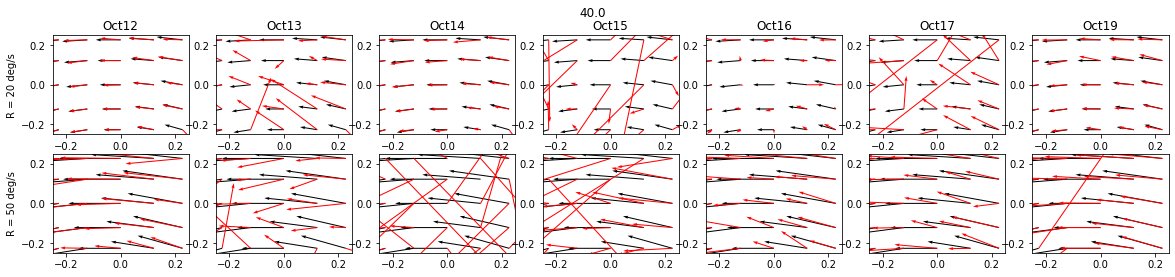

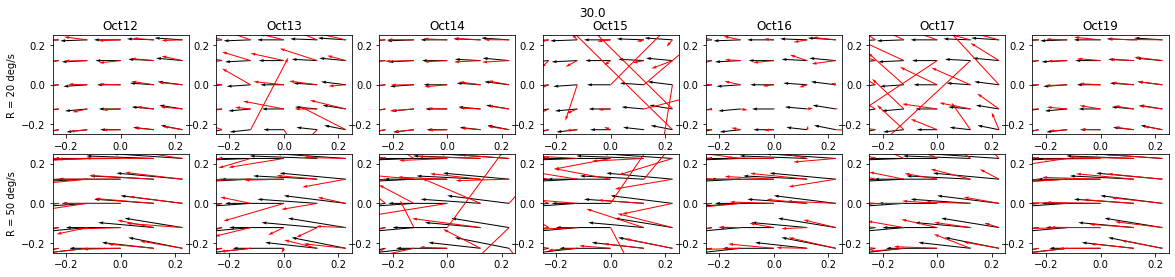

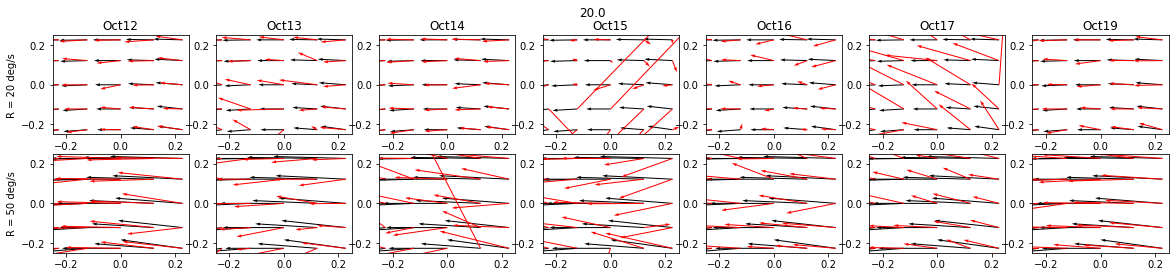

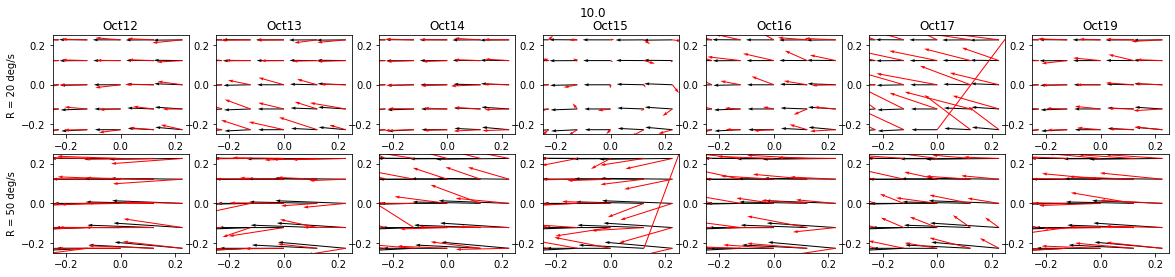

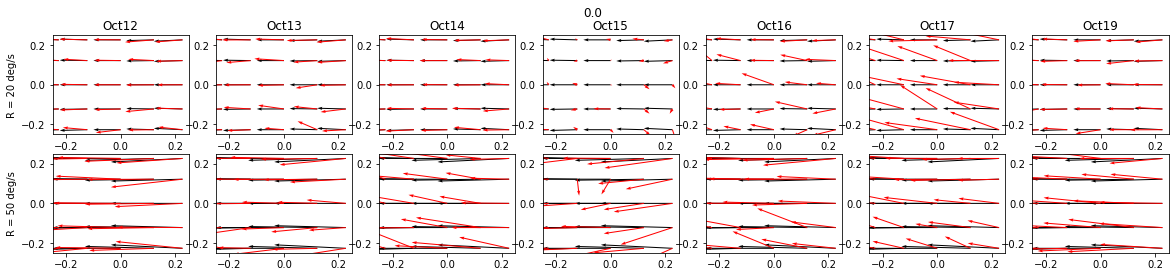

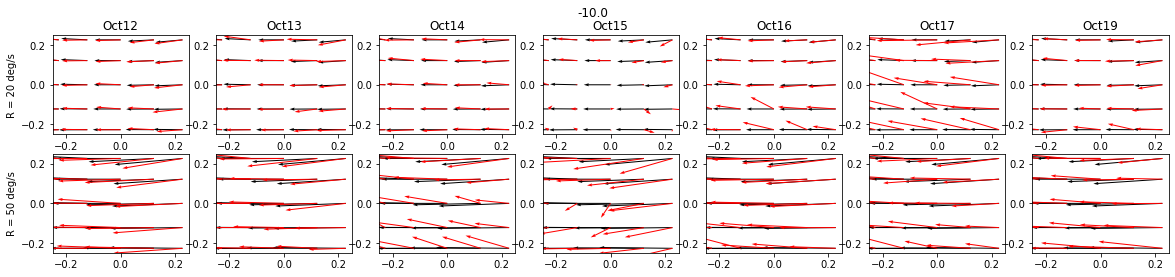

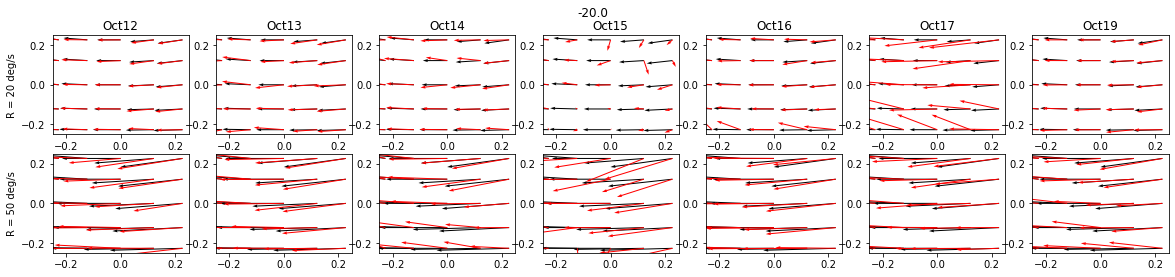

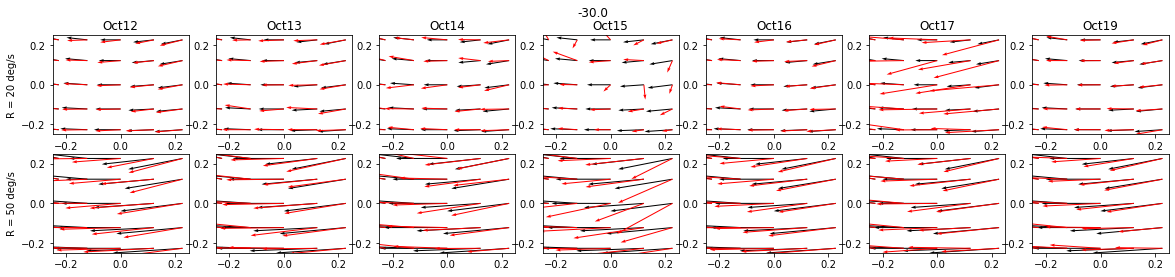

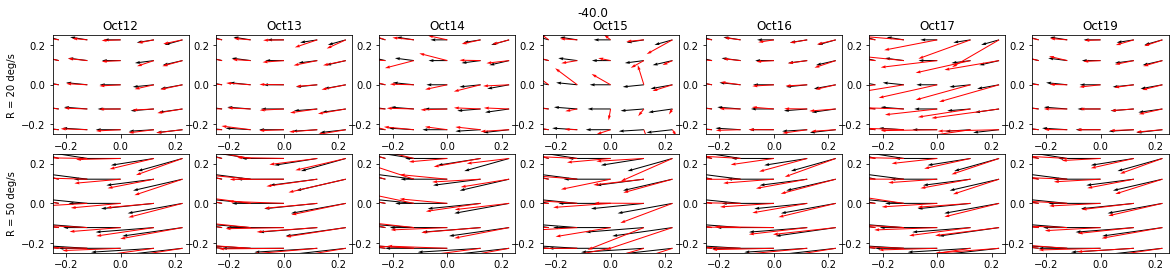

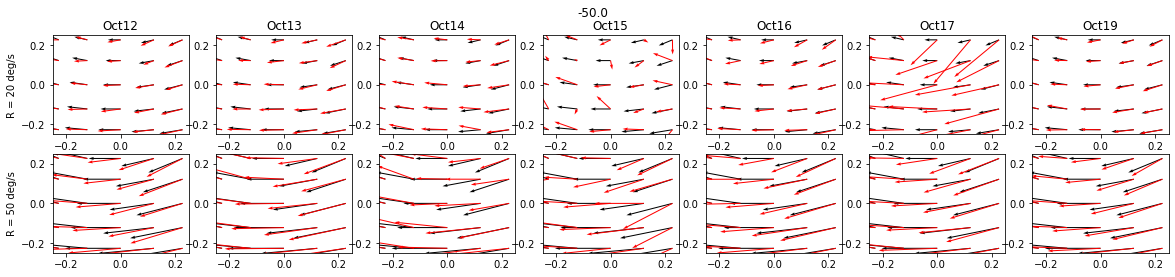

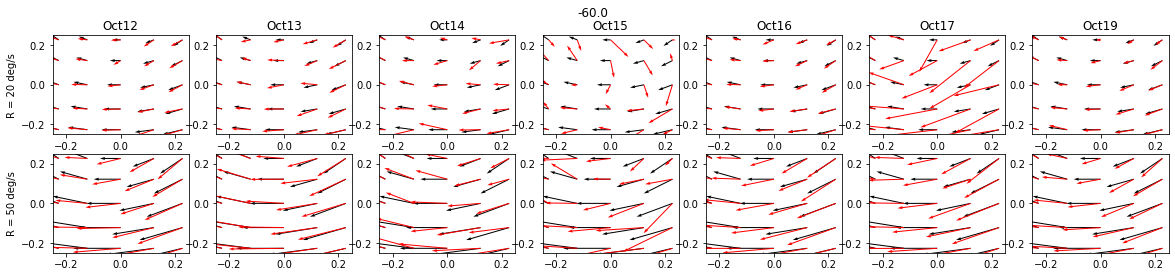

In [32]:
# show average flow from each site at each elevation
cam = 0
s = 100

for a in range(len(alphas)):
    
    # ground truth for both rotation speeds
    gt20 = getflow_local(Wy=-20*pi/180,pitch=alphas[a])*180/pi
    gt50 = getflow_local(Wy=-50*pi/180,pitch=alphas[a])*180/pi

    plt.figure(figsize=(20,4))
    plt.suptitle(alphasdeg[a])
    for d,date in enumerate(dates):

        data = np.load(f'{flowsdir}Wy_20/Wy_20_{date}.npz',allow_pickle=True)
        plt.subplot(2,len(dates),d+1)
        plt.title(date);
        plt.quiver(xx,yy,gt20[:,0],gt20[:,1],scale=s)
        plt.quiver(xx,yy,np.nanmean(data['xflow'][cam,a,:],0),np.nanmean(data['yflow'][cam,a,:],0),scale=s,color='r')
        if d == 0:
            plt.ylabel('R = 20 deg/s')

        data = np.load(f'{flowsdir}Wy_50/Wy_50_{date}.npz',allow_pickle=True)
        plt.subplot(2,len(dates),len(dates)+d+1)
        plt.quiver(xx,yy,gt50[:,0],gt50[:,1],scale=s)
        plt.quiver(xx,yy,np.nanmean(data['xflow'][cam,a,:],0),np.nanmean(data['yflow'][cam,a,:],0),scale=s,color='r')
        if d == 0:
            plt.ylabel('R = 50 deg/s')

In [33]:
# calculate and save absolute value of flow errors in deg/sec

speeds = ['Wy_50','Wy_20']
Wys = [-50,-20]
nframes = 391
comps = 2

FSerrs = np.nan*np.ones([len(speeds),len(dates),ncams,len(alphas),nframes,comps,len(xx)])
FSgrads = np.nan*np.ones_like(FSerrs)
FSconds = np.nan*np.ones_like(FSerrs)

for s,speed in enumerate(speeds):
    for d,date in enumerate(dates):
        data = np.load(f'{flowsdir}{speed}/{speed}_{date}.npz',allow_pickle=True)
        xflow = data['xflow']
        yflow = data['yflow'] 
        
        for elev,alpha in enumerate(alphas):
            gt = getflow_local(Wy=Wys[s]*pi/180,pitch=alpha)*180/pi
            for cam in range(ncams):
                for frame in range(nframes):
                    FSerrs[s,d,cam,elev,frame,0] = xflow[cam,elev,frame]-gt[:,0]
                    FSerrs[s,d,cam,elev,frame,1] = yflow[cam,elev,frame]-gt[:,1]
                    
        FSgrads[s,d,:,:,:,0,:] = data['grad']
        FSgrads[s,d,:,:,:,1,:] = data['grad']
        FSconds[s,d,:,:,:,0,:] = data['cond']
        FSconds[s,d,:,:,:,1,:] = data['cond']

FSabserrs = np.abs(FSerrs)

In [17]:
# error histograms

def plot_all_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSerrs):
    # histogram of errors separately by elevation, site, speed, and x/y
    plt.figure(figsize=(len(alphas)*4,len(dates)*4),facecolor='w')  
    j = 1
    binrange = [np.nanpercentile(np.ndarray.flatten(FSerrs),5),np.nanpercentile(np.ndarray.flatten(FSerrs),95)]
    #binrange = [-100,100]
    for d in range(len(dates)):
        for a in range(len(alphas)):
            xerrs = [e for e in np.ndarray.flatten(FSerrs[0,d,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
            yerrs = [e for e in np.ndarray.flatten(FSerrs[0,d,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
            plt.subplot(len(dates)*len(speeds),len(alphas),j)
            j = j+1
            plt.hist(xerrs,alpha=.5,bins=100,range=binrange)
            plt.hist(yerrs,color='r',alpha=.5,bins=100,range=binrange)

            xerrs = [e for e in np.ndarray.flatten(FSerrs[1,d,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
            yerrs = [e for e in np.ndarray.flatten(FSerrs[1,d,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
            plt.hist(xerrs,color='g',alpha=.5,bins=100,range=binrange)
            plt.hist(yerrs,color='y',alpha=.5,bins=100,range=binrange)


            plt.xlabel('flow error (deg/sec)')
            if a == 0:
                plt.ylabel(dates[d])
            plt.title(alphasdeg[a])
    plt.suptitle('horizontal (blue R+50, green R+20) vs vertical (red R+50, yellow R+20) FS flow errors by elevation')
    plt.tight_layout()
    
def plot_four_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSerrs):
    # histogram of errors separately by elevation, speed, and x/y
    plt.figure(figsize=(len(alphas)*4,4),facecolor='w')  
    j = 1
    binrange = [np.nanpercentile(np.ndarray.flatten(FSerrs),5),np.nanpercentile(np.ndarray.flatten(FSerrs),95)]
    #binrange = [-100,100]
    for a in range(len(alphas)):
        xerrs = [e for e in np.ndarray.flatten(FSerrs[0,:,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
        yerrs = [e for e in np.ndarray.flatten(FSerrs[0,:,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
        plt.subplot(1,len(alphas),j)
        j = j+1
        plt.hist(xerrs,alpha=.5,bins=100,range=binrange)
        plt.hist(yerrs,color='r',alpha=.5,bins=100,range=binrange)

        xerrs = [e for e in np.ndarray.flatten(FSerrs[1,:,:,a,:,0,:]) if not np.isnan(e) and not np.isinf(e)]
        yerrs = [e for e in np.ndarray.flatten(FSerrs[1,:,:,a,:,1,:]) if not np.isnan(e) and not np.isinf(e)]
        plt.hist(xerrs,color='g',alpha=.5,bins=100,range=binrange)
        plt.hist(yerrs,color='y',alpha=.5,bins=100,range=binrange)


        plt.xlabel('flow error (deg/sec)')
    plt.suptitle('horizontal (blue R+50, green R+20) vs vertical (red R+50, yellow R+20) FS flow errors by elevation')
    plt.tight_layout()
    
def plot_combined_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSerrs):

    # histogram of errors collapsing across everything except elevation
    plt.figure(figsize=(12,12),facecolor='w')  
    j = 1
    #binrange = [np.nanpercentile(np.ndarray.flatten(FSerrs),5),np.nanpercentile(np.ndarray.flatten(FSerrs),95)]
    binrange = [-100, 100]
    for a in range(len(alphas)):
        errs = [e for e in np.ndarray.flatten(FSerrs[:,:,:,a,:,:,:]) if not np.isnan(e) and not np.isinf(e)]
        plt.subplot(4,3,j)
        j = j+1
        plt.hist(errs,alpha=.5,bins=100,range=binrange,density=True)
        plt.ylim(0,.18)
        plt.xlabel('flow error (deg/sec)')
        plt.title(alphasdeg[a])

    plt.tight_layout()

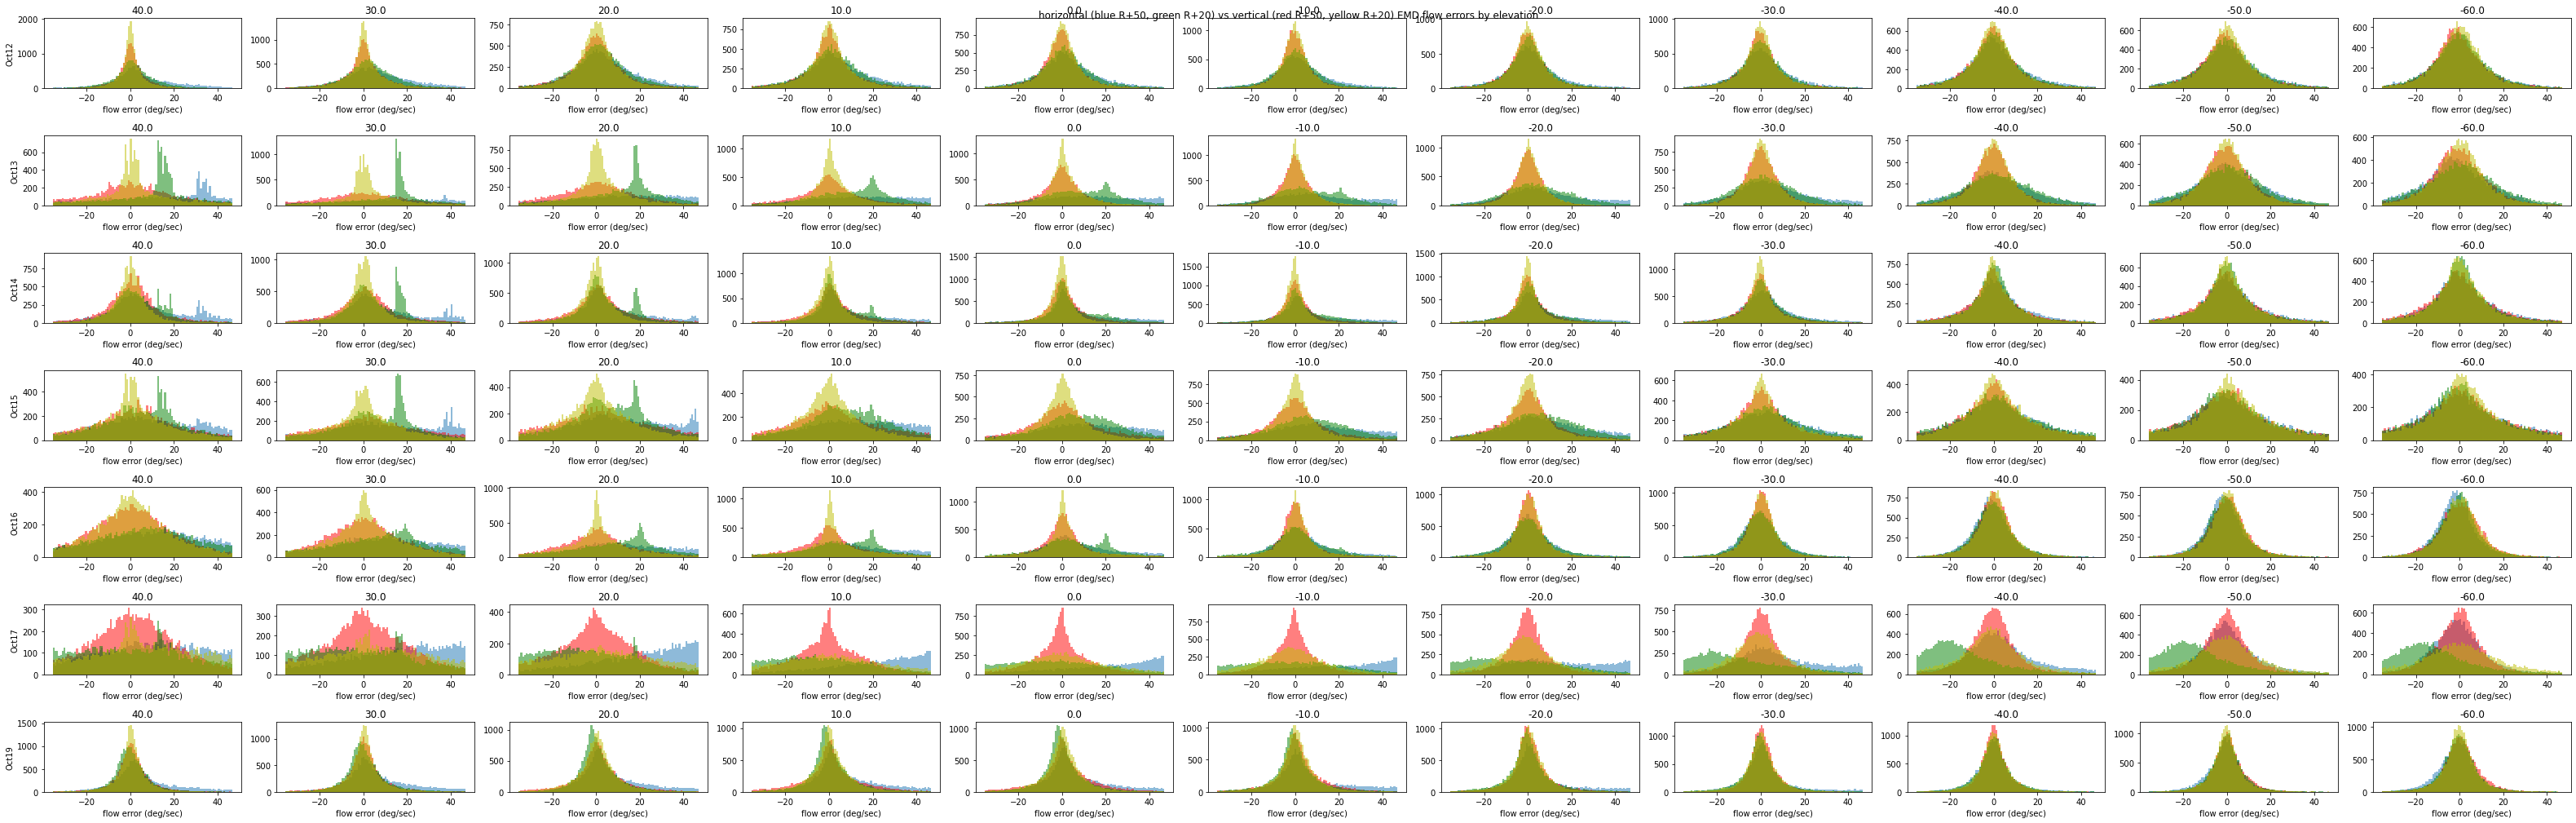

In [17]:
plot_all_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSerrs)

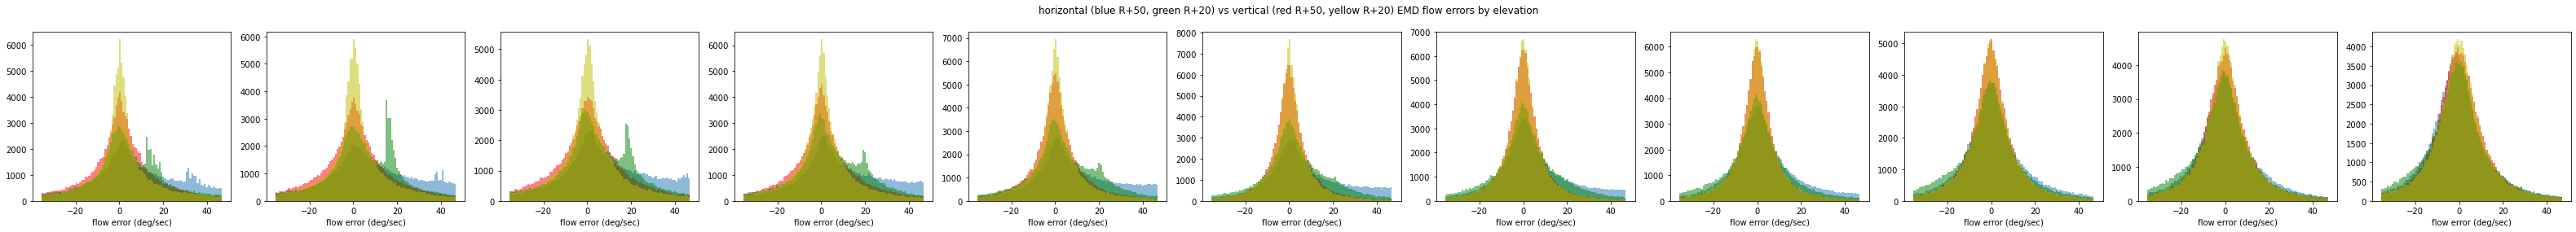

In [18]:
plot_four_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSerrs)

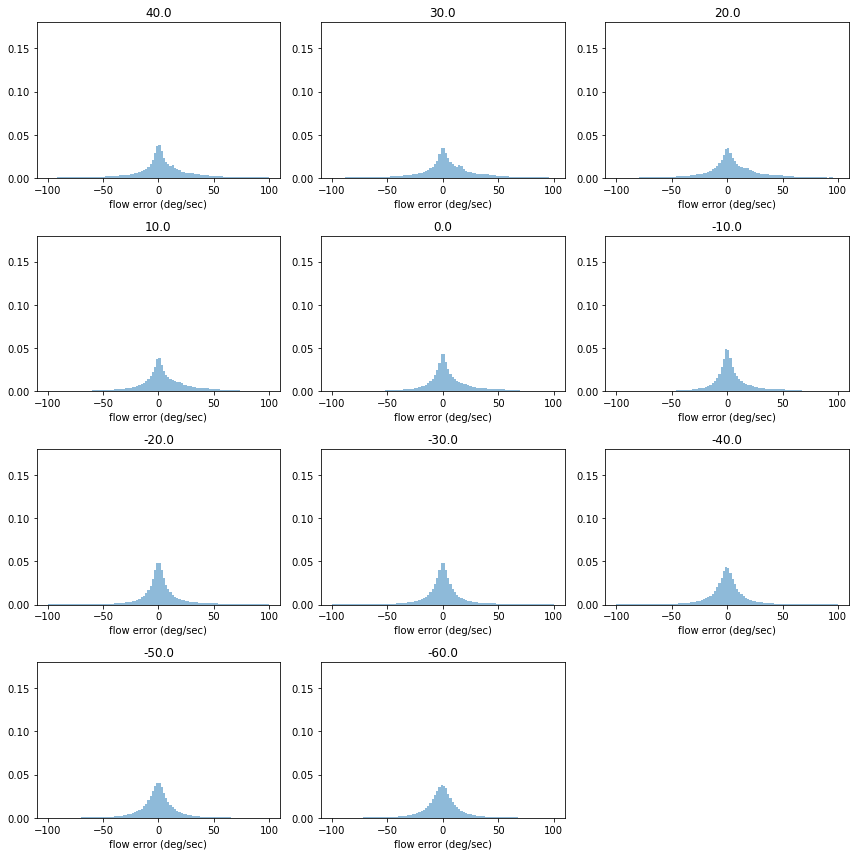

In [19]:
plot_combined_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSerrs)

In [35]:
FSfilterederrs = np.copy(FSerrs)
FSfilterederrs[FSconds>cond_cut_off] = np.nan
FSfilterederrs[FSabserrs>100] = np.nan

In [42]:
for grad_cut_off in [1e-5,1e-4]:
    sample = np.copy(FSfilterederrs)
    sample[FSgrads<grad_cut_off] = np.nan
    perelevsizes = [np.sum(~np.isnan(sample[:,:,:,a,:,:,:])) for a in range(len(alphas))]
    perelevmax = 560000
    print(min(perelevsizes),max(perelevsizes),perelevmax,min(perelevsizes)/perelevmax,max(perelevsizes)/perelevmax)
    newnans = np.sum(np.isnan(sample))-np.sum(np.isnan(FSerrs))
    print(f'total exclusion rate: {newnans/np.sum(~np.isnan(FSerrs))}')

176031 407755 560000 0.31434107142857143 0.7281339285714286
total exclusion rate: 0.4399062859868715
101015 326832 560000 0.18038392857142857 0.5836285714285714
total exclusion rate: 0.6128020312702491


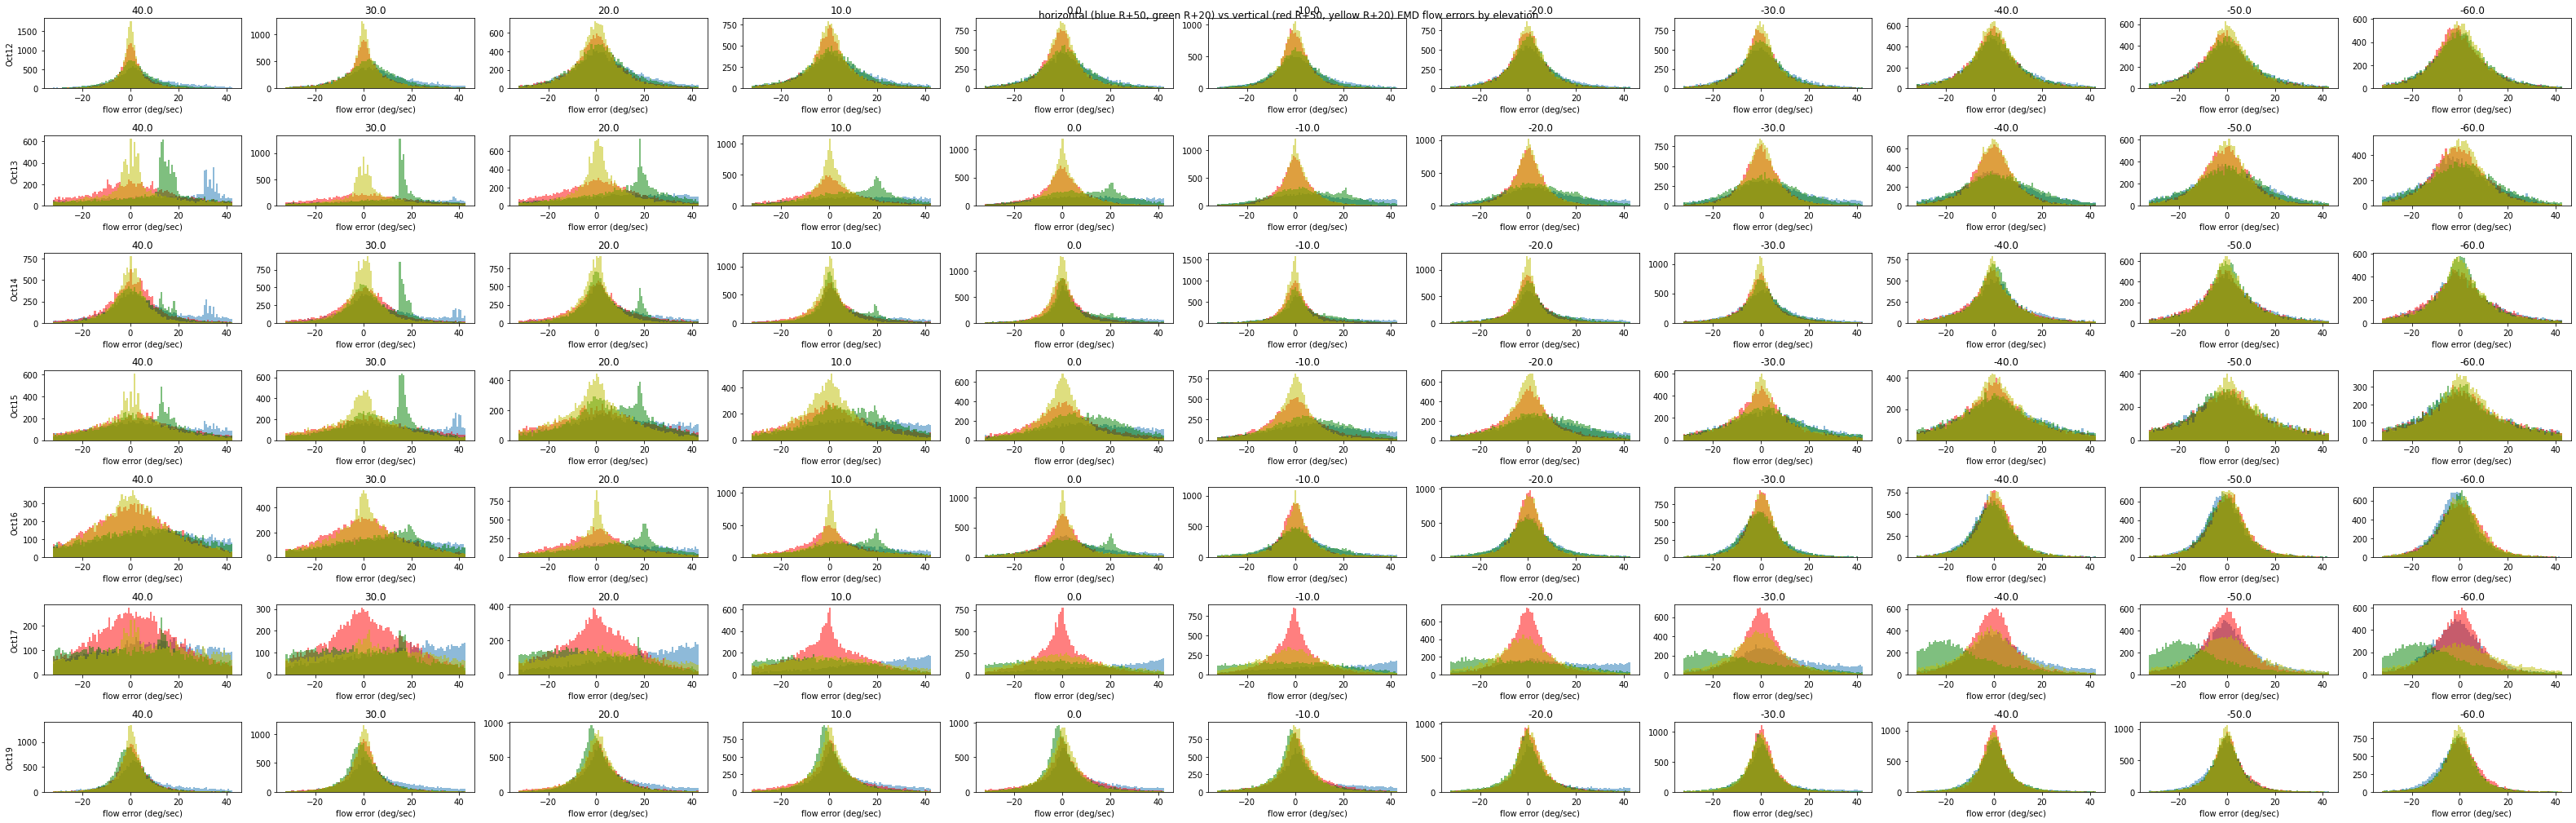

In [18]:
plot_all_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSfilterederrs)

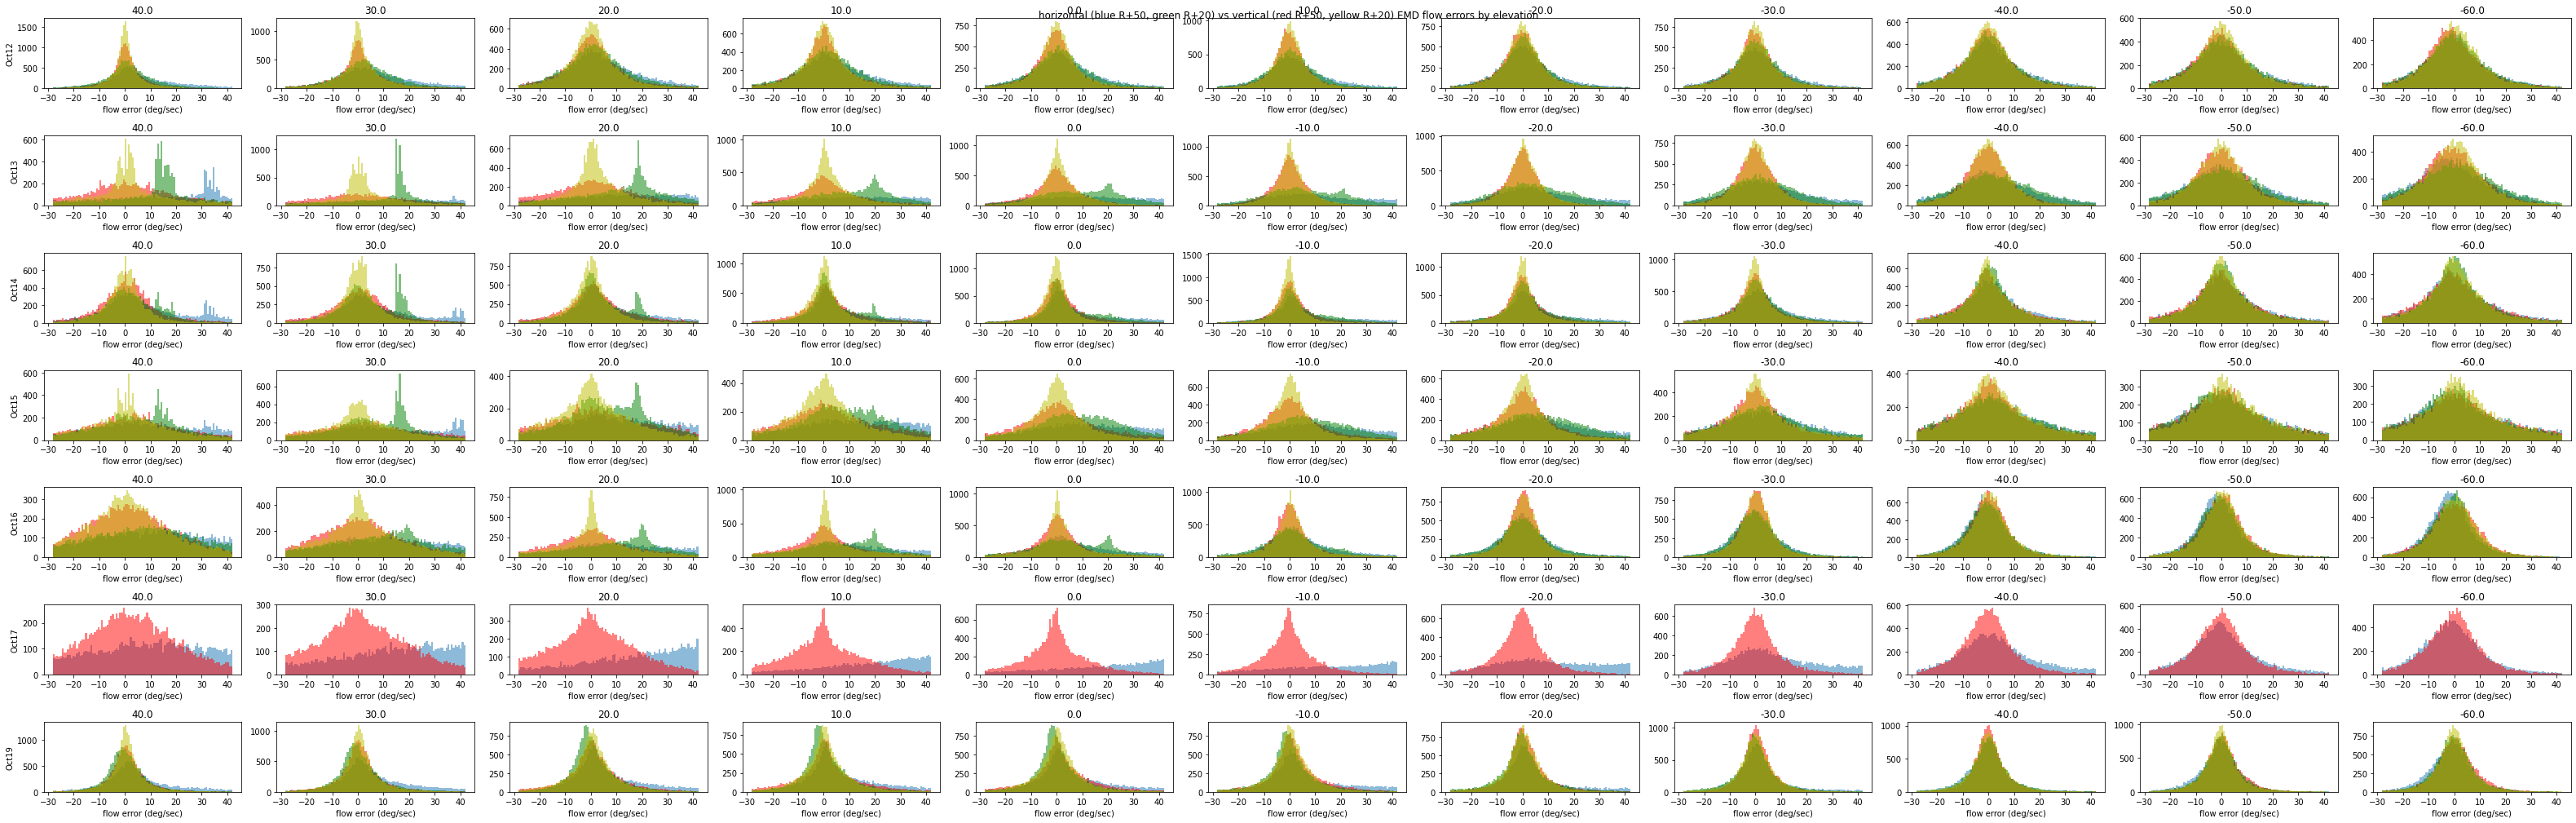

In [19]:
# data clean up
FSfilterederrs = np.copy(FSerrs)
FSfilterederrs[FSconds>cond_cut_off] = np.nan
FSfilterederrs[FSabserrs>100] = np.nan  # scene stats are warped by large errors: drop errors larger than 100 deg/sec
FSfilterederrs[1,5,...] = np.nan# removing bad site - Oct17 Wy20 had camera malfunction

plot_all_histograms(alphas=alphas,alphasdeg=alphasdeg,dates=dates,speeds=speeds,FSerrs=FSfilterederrs)

In [12]:
# calculate scene stats: sparsity, variance of errors, and kurtosis of errors

from scipy import stats

# apply data filters and calculate sparsity, variance, and kurtosis by site and overall
def errstats(errs,grads,conds,errcutoff=100,condcutoff=100,gradcutoff=1e-5,verbose=False):
    
    # exclude data 
    filterederrs = np.copy(errs)
    filterederrs[errs>errcutoff] = np.nan    # remove high errors
    filterederrs[grads<gradcutoff] = np.nan  # remove low gradients
    filterederrs[conds>condcutoff] = np.nan  # remove high condition numbers
    filterederrs[1,5,...] = np.nan           # remove site with camera malfunction
    
    sparsities_bysite = np.nan*np.ones([len(alphas),len(dates)]) #len(Wys)*ncams*nframes*patchsz potential samples
    vars_bysite = np.nan*np.ones_like(sparsities_bysite)
    kurtoses_bysite = np.nan*np.ones_like(sparsities_bysite)

    sparsities_overall = np.nan*np.ones([len(alphas)])
    vars_overall = np.nan*np.ones_like(sparsities_overall)
    kurtoses_overall = np.nan*np.ones_like(sparsities_overall)

    for a in range(len(alphas)):

        nsamps_a = 0 # track number of present samples
        Nsamps_a = 0 # track number of samples that could have been present

        for d in range(len(dates)):

            keyframes = 0
            nsamps_ad = 0
            Nsamps_ad = 0

            # count present and potential samples
            for s in range(2): # different keyframes from different speed videos
                if s == 1 and d == 5: # don't include Oct17 Wy20 in sparsity calculation
                    continue
                i = 0
                while i < nframes:
                    # skip keyframes
                    if np.all(np.isnan(grads[s,d,:,a,i:i+9,:,:])):
                        i = i+9
                        keyframes = keyframes + 1
                        continue

                    nsamps_ad = nsamps_ad + np.sum(~np.isnan(filterederrs[:,d,:,a,i,:,:]))
                    Nsamps_ad = Nsamps_ad + np.size(filterederrs[:,d,:,a,i,:,:])
                    i = i+1

            sparsities_bysite[a,d] = (Nsamps_ad-nsamps_ad)/Nsamps_ad*100

            nsamps_a = nsamps_a + nsamps_ad
            Nsamps_a = Nsamps_a + Nsamps_ad

            vars_bysite[a,d] = np.nanvar(filterederrs[:,d,:,a,:,:,:])
            kurtoses_bysite[a,d] = stats.kurtosis(np.ndarray.flatten(filterederrs[:,d,:,a,:,:,:]),nan_policy='omit')

            if verbose:
                print(keyframes,end=' ')
                
        sparsities_overall[a] = (Nsamps_a - nsamps_a)/Nsamps_a*100
        vars_overall[a] = np.nanvar(filterederrs[:,:,:,a,:,:,:])
        kurtoses_overall[a] = stats.kurtosis(np.ndarray.flatten(filterederrs[:,:,:,a,:,:,:]),nan_policy='omit')
    return filterederrs,sparsities_bysite,vars_bysite,kurtoses_bysite,sparsities_overall,vars_overall,kurtoses_overall
    
def ploterrstats(sparsities_bysite,variances_bysite,kurtoses_bysite,title=None,color='b',newfig=True):
    xticks = [-60,-40,-20,0,20,40]
    if newfig:
        plt.figure(figsize=(10,2.5),facecolor='w')

    plt.subplot(1,4,1)
    for d in range(len(dates)):
        plt.plot(alphasdeg,sparsities_bysite[:,d],color=color,alpha=.2)
    means = np.nanmean(sparsities_bysite,axis=1)
    stderrs = np.sqrt(np.nanvar(sparsities_bysite,axis=1))/np.sqrt(len(dates))
    plt.plot(alphasdeg,means,'-',color=color)
    plt.fill_between(alphasdeg,means-stderrs,means+stderrs,color=color,alpha=.2)
    plt.xlabel('elevation ($^\circ$)')
    plt.xlim(-60,40)
    plt.ylim(0,100)
    plt.xticks(xticks)
    plt.ylabel('sparsity (%)')

    plt.subplot(1,4,2)
    for d in range(len(dates)):
        plt.plot(alphasdeg,vars_bysite[:,d],color=color,alpha=.2)
    means = np.nanmean(vars_bysite,axis=1)
    stderrs = np.sqrt(np.nanvar(vars_bysite,axis=1))/np.sqrt(len(dates))
    plt.plot(alphasdeg,means,'-',color=color)
    plt.fill_between(alphasdeg,means-stderrs,means+stderrs,color=color,alpha=.2)
    plt.xlabel('elevation ($^\circ$)')
    plt.xlim(-60,40)
    plt.ylim(0,2000)
    plt.xticks(xticks)
    plt.ylabel('variance ($^\circ$/s)$^2$')

    plt.subplot(1,4,3)
    for d in range(len(dates)):
        plt.plot(alphasdeg,kurtoses_bysite[:,d],color=color,alpha=.2)
    means = np.nanmean(kurtoses_bysite,axis=1)
    stderrs = np.sqrt(np.nanvar(kurtoses_bysite,axis=1))/np.sqrt(len(dates))
    plt.plot(alphasdeg,means,'-',color=color)
    plt.fill_between(alphasdeg,means-stderrs,means+stderrs,color=color,alpha=.2)
    plt.xlabel('elevation ($^\circ$)')
    plt.xlim(-60,40)
    plt.xticks(xticks)
    plt.ylabel('kurtosis')
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    return

[27.21299521 23.40313452 21.01774053 22.17305181 23.95102307 23.72322595
 17.7618633  12.31062255  9.94438398  9.51567262  9.43752721]


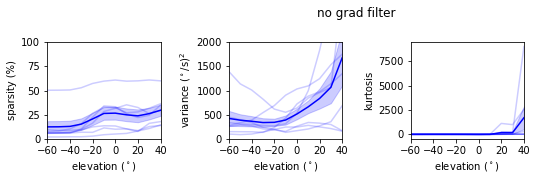

In [13]:
# show effects of different filtering
title = 'no grad filter'
_,sparsities_bysite,vars_bysite,kurtoses_bysite,sparsities_overall,_,_ = errstats(FSerrs,grads=FSgrads,conds=FSconds,
                                                                 errcutoff=100,condcutoff=1000,gradcutoff=0)
ploterrstats(sparsities_bysite,vars_bysite,kurtoses_bysite,title=title)
print(sparsities_overall)

10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 [67.39508054 64.40313452 61.27154985 61.73019155 59.83924684 57.21821942
 43.15128428 33.77688289 26.85491946 23.92087505 23.51425773]
10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 10 10 10 9 10 5 10 [78.43600348 78.29680017 79.62984327 78.92577275 75.61373531 68.8321724
 58.55605137 51.37135394 44.88833261 40.39834567 37.77622987]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


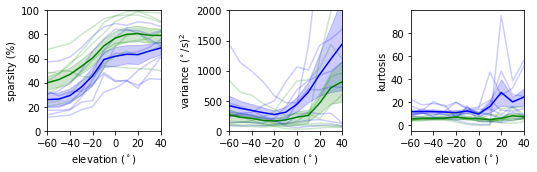

In [14]:
# try pairs of cutoffs
cutoffs = [[100,1e-5],[100,1e-4]]
colors = ['b','g']
newfig = [True,False]
for c,cutoff in enumerate(cutoffs):
    #title = f'err filter 100, cond filter {cutoff[0]}, grad filter {cutoff[1]}'
    title = None
    _,sparsities_bysite,vars_bysite,kurtoses_bysite,sparsities_overall,_,_ = errstats(FSerrs,
                                                                     grads=FSgrads,
                                                                     conds=FSconds,
                                                                     condcutoff=cutoff[0],
                                                                     gradcutoff=cutoff[1],
                                                                     verbose=True)
    ploterrstats(sparsities_bysite,vars_bysite,kurtoses_bysite,title=title,color=colors[c],newfig=newfig[c])
    print(sparsities_overall)

os.makedirs('./final_plots/',exist_ok=True)
plt.savefig(f'./final_plots/final_FS_noisemodel.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_FS_noisemodel.eps', format='eps',dpi=300)

In [15]:
# fit generalized Gaussians to error distributions

from scipy.optimize import minimize,least_squares
from scipy import stats
from scipy.special import gamma

# generalized Gaussian model
def prob(x,params):
    sigma,beta = params
    return beta/(2*sigma*gamma(1/beta)) * np.exp(-np.abs(x/sigma)**beta)
def loglikelihood(xs,params):
    L = 0
    for x in xs:
        L = L+np.log(prob(x,params))
    return L

# initial params for gen gauss model
params0 = [1,.5]

#binlim = 100
binlim = 50


def modelfromdata(errs,params0=params0,color='gray'):
    
    params = np.nan*np.ones([len(alphas),2])
    perfs = np.nan*np.ones(len(alphas))
    
    plt.figure(figsize=(2,18),facecolor='w')  
    #plt.figure(figsize=(4*len(alphas),4),facecolor='w')
    for a in range(len(alphas)):
        dxdylist = np.ndarray.flatten(errs[:,:,:,a,...])
        data = [d for d in dxdylist if not np.isnan(d)]
        
        ax1 = plt.subplot(len(alphasdeg),1,a+1)
        hist, bin_edges, _ = plt.hist(data,bins=5*patchsz,range=[-binlim,binlim],facecolor=color,density=True)
        plt.ylim(0,.2)
        plt.xticks([-50,0,50],[])
        plt.yticks([0,.1,.2],[])
        if a == len(alphasdeg)-1:
            plt.xticks([-50,0,50],[-50,0,50])
            plt.xlabel('flow error (deg/sec)')
        
        plt.tight_layout()
        
        
        def negloglikelihood(params):
            return -loglikelihood(data,params)/len(data)
    
        try:
            res = minimize(negloglikelihood,params0,method='Nelder-Mead')
            params[a] = res['x']
            perfs[a] = -negloglikelihood(res['x'])
            plt.plot(bin_edges,prob(bin_edges,res['x']),'--k')
        except Exception as e:
            print(e)
    return params,perfs


sitecolors = ['red','darkorange','gold','lime','turquoise','dodgerblue','indigo','violet']

def modelfromdata_bysite(errs,color='gray',nsamples=-1,init=None,params0=params0):
    
    params = np.nan*np.ones([len(alphas),len(dates),2])
    perfs = np.nan*np.ones([len(alphas),len(dates)])
    
    plt.figure(figsize=(4*len(alphas),4*len(dates)),facecolor='w')
    for d in range(len(dates)):
        for a in range(len(alphas)):
            dxdylist = np.ndarray.flatten(errs[:,d,:,a,...])
            data = [datum for datum in dxdylist if not np.isnan(datum)]
            if len(data) == 0:
                continue
            if nsamples>0:
                data = random.shuffle(np.copy(data))
                data = data[:nsamples]
        
            plt.subplot(len(dates),len(alphas),d*len(alphas)+len(alphas)-a)
            hist, bin_edges, _ = plt.hist(data,bins=5*patchsz,range=[-binlim,binlim],facecolor=sitecolors[d],density=True)
            plt.ylim(0,.2)
            plt.title(f'{alphasdeg[a]}')

            def negloglikelihood(params):
                return -loglikelihood(data,params)/len(data)
            if init is not None:
                params0 = init[a]
            res = minimize(negloglikelihood,params0,method='Nelder-Mead')

            params[a,d] = res['x']
            perfs[a,d] = -negloglikelihood(res['x'])
            plt.plot(bin_edges,prob(bin_edges,res['x']),'-k')
    return params,perfs

[100, 1e-05]
[[5.80200798 0.62348484]
 [7.40977222 0.67756233]
 [7.453949   0.6957459 ]
 [5.85091536 0.65018788]
 [4.60132385 0.63456327]
 [4.55511205 0.67643774]
 [5.33933707 0.72290557]
 [6.20683927 0.7489752 ]
 [7.41741088 0.78316624]
 [8.12447712 0.80010563]
 [8.70822659 0.81620346]]
[-4.4155738  -4.43969027 -4.38076921 -4.3095303  -4.13481805 -3.9572925
 -3.95758311 -4.02957919 -4.11429917 -4.1626388  -4.19343567]
[100, 0.0001]
[[3.99696437 0.60115734]
 [4.32641709 0.63828529]
 [4.59970119 0.71239452]
 [3.99257113 0.71552029]
 [3.9315006  0.73467338]
 [4.5674312  0.79315019]
 [5.07726186 0.79983146]
 [5.72412255 0.81096243]
 [6.75218297 0.82503089]
 [7.60707337 0.85143377]
 [8.31609976 0.86289857]]
[-4.14814442 -4.05724784 -3.84214599 -3.69045095 -3.61520337 -3.6039772
 -3.69320506 -3.78622002 -3.91864891 -3.97996303 -4.04528156]


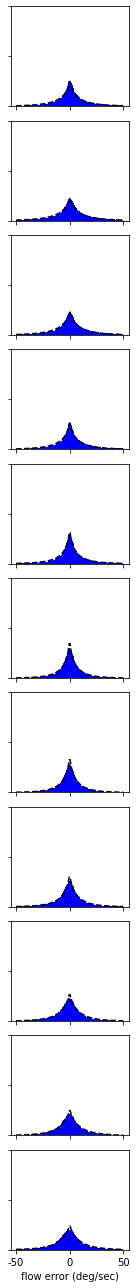

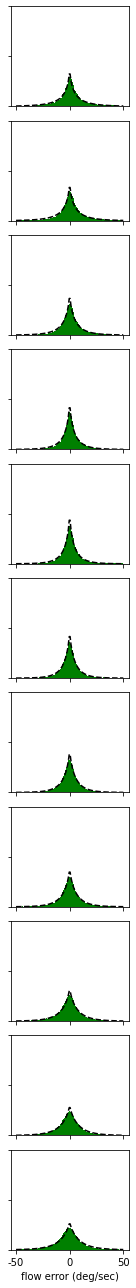

In [16]:
cutoffs = [[100,1e-5],[100,1e-4]]
colors = ['b','g']
for c in range(2):
    cutoff = cutoffs[c]
    FSfilterederrs = np.copy(FSerrs)
    FSfilterederrs[FSconds>cutoff[0]] = np.nan
    FSfilterederrs[FSgrads<cutoff[1]] = np.nan
    FSfilterederrs[FSabserrs>100] = np.nan

    params,perfs = modelfromdata(FSfilterederrs,color=colors[c])
    print(cutoff)
    print(params)
    print(perfs)
    
    if c == 0:
        plt.savefig(f'./final_plots/final_FS_distributions_loose.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/final_FS_distributions_loose.eps', format='eps',dpi=300)
    else:
        plt.savefig(f'./final_plots/final_FS_distributions_tight.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/final_FS_distributions_tight.eps', format='eps',dpi=300)